In [1]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import heapq as hq

In [4]:
def completeGraph(nVertices):
    # Initialize the graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(nVertices))

    # List all possible edges
    edges = list(nx.non_edges(G))
    random.shuffle(edges)
    while not nx.is_connected(G):
        x, y = edges.pop()
        G.add_edge(x, y)

    return G

In [5]:
def drawGraph(G):
    plt.figure(figsize = (12,8), dpi = 50)
    nx.draw_networkx(G,
                     with_labels = True,
                     style = "solid",
                     node_size = 700,
                     node_color = "orange",
                     font_size = 14,
                     font_color = "black",
                     font_weight = "bold")
    plt.show()

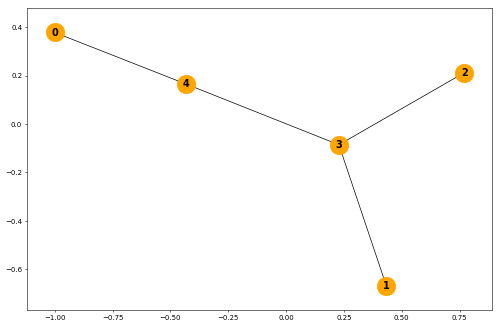

In [7]:
G = completeGraph(5)
drawGraph(G)

In [39]:
class FlowUpdating:
    def __init__(self, neighbors, inputValue, timeout):
        self.timeout = timeout
        self.messages = []
        self.neighbors = neighbors
        self.f = {}
        self.e = {}
        for n in neighbors:
            self.f[n] = 0
            self.e[n] = 0
        self.v = inputValue

    def gen_message(self):
        messages = [("TIMEOUT", self.timeout, True)]
        for n in self.neighbors:
            msg = (self.f[n], self.e[n])
            messages.append(("FLOW", (n, msg)))
        return messages

    def calculateEstimate(self):
        sumF = 0
        sumE = 0
        for n in self.neighbors:
            sumF += self.f[n]
            sumE += self.e[n]
        return (self.v - sumF + sumE) / (len(self.neighbors) + 1)

    def state_transition(self):
        for m in self.messages:
            src = m[0]
            (f, e) = m[1]
            self.f[src] = -f
            self.e[src] = e

        newE = self.calculateEstimate()
        stop = True
        for n in self.neighbors:
            print(round(newE, 2), round(self.e[n], 2))
            if round(newE, 2) != round(self.e[n], 2):
                stop = False
            self.f[n] += newE - self.e[n]
            self.e[n] = newE

        return stop

    def handle(self, src, msg):
        if msg == "INITIAL":
            return self.gen_message()
        else:
            if msg[0] == "FLOW":
                self.messages.append((src, msg[1]))
            else: # timeout message, end of round
                if not self.state_transition():
                    return self.gen_message()
        return []

In [24]:
class Simulator:
    def __init__(self, nodes, distances, faultProbability, viewChange):
        self.nodes = nodes
        self.distances = distances
        self.currentTime = 0
        self.pending = [] # [(delay, (src, dest, msg))]
        self.faultProbability = faultProbability
        self.viewChange = viewChange

    def start(self):
        for n in self.nodes:
            event = (0, (None, n, "INITIAL"))
            hq.heappush(self.pending, event)

        # Add first view change
        if self.viewChange != -1:
            hq.heappush(self.pending, (self.viewChange, (float("+infinity"), None, "VIEWCHANGE")))

        return self.runLoop()

    def runLoop(self):
        sent_messages = len(self.pending)
        while len(self.pending) != 0:
            if len(self.pending) == 1:
                (delay, (src, dest, msg)) = self.pending[0]
                if msg == "VIEWCHANGE":
                    break

            (delay, (src, dest, msg)) = hq.heappop(self.pending)
            print(dest, "received", msg, "from", src, "at", delay)
            self.currentTime = delay

            # Message to change the view
            if msg == "VIEWCHANGE":
                print("View changing...")

                vc = (self.currentTime + self.viewChange, (float("+infinity"), None, "VIEWCHANGE"))
                print("VIEWCHANGE", vc)
                hq.heappush(self.pending, vc)

                newGraph = completeGraph(len(self.nodes))
                drawGraph(newGraph)
                self.distances, self.nodes = newNeighborsAndDistances(newGraph, self.nodes, random.randrange(10), False)
                continue

            # Message between two nodes or a timeout
            newEvents = self.nodes[dest].handle(src, msg)

            if newEvents:
                sent_messages += len(newEvents)
                for x in newEvents:
                    if x[0] != "TIMEOUT":
                        (msgType, (newMsgDest, newMsg)) = x
                        if self.faultProbability != 0 and random.randrange(round(1/self.faultProbability)) == 0: # fault-injection mechanism
                            print("Dropped", newMsg, "from", dest, "to", newMsgDest)
                            continue
                        dist = 0
                        if (dest, newMsgDest) not in self.distances and (newMsgDest, dest) not in self.distances:
                            print("Dropped one message from", dest, "to", newMsgDest, "because they are no longer neighbors")
                            continue
                        if dest < newMsgDest:
                            dist = self.distances[(dest, newMsgDest)]
                        else:
                            dist = self.distances[(newMsgDest, dest)]

                        ev = (self.currentTime + dist, (dest, newMsgDest, (msgType, newMsg)))
                        hq.heappush(self.pending, ev)
                    else:
                        (msgType, timeout, newMsg) = x
                        ev = (self.currentTime + timeout, (dest, dest, (msgType, timeout, newMsg)))
                        hq.heappush(self.pending, ev)

        print()
        return sent_messages, self.currentTime

In [17]:
def newNeighborsAndDistances(G, nodes, flag):
    distances = {}
    for node in G.nodes():
        neighbors = set(G.neighbors(node))
        if flag:
            nodes[node] = FlowUpdating(neighbors, 5, 3)
        else:
            nodes[node].change_neighbors(neighbors)

        for neighbor in neighbors:
            if node < neighbor:
                distances[(node, neighbor)] = 1 # rand.randrange(10)
            else:
                distances[(neighbor, node)] = 1 # rand.randrange(10)

    return distances, nodes

In [18]:
def main():
    N = 5 # number of rounds
    fanout = 1
    messages_sent = 0
    rounds = 0
    max_rounds = float("-infinity")
    min_rounds = float("+infinity")

    for i in range(N):
        distances, nodes = newNeighborsAndDistances(G, {}, True)

        fp = 0 # fault-probability - probability for a message to be lost
        vcp = -1  # view-change periodicity - every vcp seconds, the set of neighbors change
        sim = Simulator(nodes, distances, fp, vcp)
        x, y = sim.start()
        messages_sent += x
        rounds += y

        if y > max_rounds:
            max_rounds = y
        if y < min_rounds:
            min_rounds = y

    print("Average rounds:", float(rounds / N))
    print("Average messages sent:", float(messages_sent / N))
    print("Min rounds:", min_rounds)
    print("Max rounds:", max_rounds)

In [40]:
main()

0 received INITIAL from None at 0
1 received INITIAL from None at 0
2 received INITIAL from None at 0
3 received INITIAL from None at 0
4 received INITIAL from None at 0
4 received ('FLOW', (0, 0)) from 0 at 1
3 received ('FLOW', (0, 0)) from 1 at 1
3 received ('FLOW', (0, 0)) from 2 at 1
1 received ('FLOW', (0, 0)) from 3 at 1
2 received ('FLOW', (0, 0)) from 3 at 1
4 received ('FLOW', (0, 0)) from 3 at 1
0 received ('FLOW', (0, 0)) from 4 at 1
3 received ('FLOW', (0, 0)) from 4 at 1
0 received ('TIMEOUT', 3, True) from 0 at 3
2.5 0.0
1 received ('TIMEOUT', 3, True) from 1 at 3
2.5 0.0
2 received ('TIMEOUT', 3, True) from 2 at 3
2.5 0.0
3 received ('TIMEOUT', 3, True) from 3 at 3
1.25 0.0
1.25 0.0
1.25 0.0
4 received ('TIMEOUT', 3, True) from 4 at 3
1.67 0.0
1.67 0.0
4 received ('FLOW', (5/2, 5/2)) from 0 at 4
3 received ('FLOW', (5/2, 5/2)) from 1 at 4
3 received ('FLOW', (5/2, 5/2)) from 2 at 4
1 received ('FLOW', (5/4, 5/4)) from 3 at 4
2 received ('FLOW', (5/4, 5/4)) from 3 at 4
4

3.75
5.0 3.75
5.0 5.0
4 received ('TIMEOUT', 3, True) from 4 at 63
5.0 4.17
5.0 5.0
1 received ('FLOW', (5/241864704, 1209323525/241864704)) from 3 at 64
2 received ('FLOW', (5/241864704, 1209323525/241864704)) from 3 at 64
4 received ('FLOW', (-5/80621568, 1209323525/241864704)) from 3 at 64
0 received ('FLOW', (5/181398528, 906992645/181398528)) from 4 at 64
3 received ('FLOW', (-5/90699264, 906992645/181398528)) from 4 at 64
3 received ('TIMEOUT', 3, True) from 3 at 66
5.0 3.75
5.0 3.75
5.0 5.0
4 received ('TIMEOUT', 3, True) from 4 at 66
5.0 4.17
5.0 5.0
1 received ('FLOW', (-5/725594112, 3627970555/725594112)) from 3 at 67
2 received ('FLOW', (-5/725594112, 3627970555/725594112)) from 3 at 67
4 received ('FLOW', (5/241864704, 3627970555/725594112)) from 3 at 67
0 received ('FLOW', (-5/362797056, 1813985275/362797056)) from 4 at 67
3 received ('FLOW', (5/181398528, 1813985275/362797056)) from 4 at 67
3 received ('TIMEOUT', 3, True) from 3 at 69
5.0 3.75
5.0 3.75
5.0 5.0
4 received 


5.0 3.75
5.0 5.0
4 received ('TIMEOUT', 3, True) from 4 at 159
5.0 4.17
5.0 5.0
1 received ('FLOW', (5/682326912718312833024, 3411634563591564165125/682326912718312833024)) from 3 at 160
2 received ('FLOW', (5/682326912718312833024, 3411634563591564165125/682326912718312833024)) from 3 at 160
4 received ('FLOW', (-5/227442304239437611008, 3411634563591564165125/682326912718312833024)) from 3 at 160
0 received ('FLOW', (5/511745184538734624768, 2558725922693673123845/511745184538734624768)) from 4 at 160
3 received ('FLOW', (-5/255872592269367312384, 2558725922693673123845/511745184538734624768)) from 4 at 160
3 received ('TIMEOUT', 3, True) from 3 at 162
5.0 3.75
5.0 3.75
5.0 5.0
4 received ('TIMEOUT', 3, True) from 4 at 162
5.0 4.17
5.0 5.0
1 received ('FLOW', (-5/2046980738154938499072, 10234903690774692495355/2046980738154938499072)) from 3 at 163
2 received ('FLOW', (-5/2046980738154938499072, 10234903690774692495355/2046980738154938499072)) from 3 at 163
4 received ('FLOW', (5/68


3 received ('FLOW', (-5/20051241808265601101758268964864, 200512418082656011017582689648645/40102483616531202203516537929728)) from 4 at 244
3 received ('TIMEOUT', 3, True) from 3 at 246
5.0 3.75
5.0 3.75
5.0 5.0
4 received ('TIMEOUT', 3, True) from 4 at 246
5.0 4.17
5.0 5.0
1 received ('FLOW', (-5/160409934466124808814066151718912, 802049672330624044070330758594555/160409934466124808814066151718912)) from 3 at 247
2 received ('FLOW', (-5/160409934466124808814066151718912, 802049672330624044070330758594555/160409934466124808814066151718912)) from 3 at 247
4 received ('FLOW', (5/53469978155374936271355383906304, 802049672330624044070330758594555/160409934466124808814066151718912)) from 3 at 247
0 received ('FLOW', (-5/80204967233062404407033075859456, 401024836165312022035165379297275/80204967233062404407033075859456)) from 4 at 247
3 received ('FLOW', (5/40102483616531202203516537929728, 401024836165312022035165379297275/80204967233062404407033075859456)) from 4 at 247
3 received ('TI

5.0 5.0
1 received ('FLOW', (-5/44904515414709114480174422247585349632, 224522577073545572400872111237926748155/44904515414709114480174422247585349632)) from 3 at 289
2 received ('FLOW', (-5/44904515414709114480174422247585349632, 224522577073545572400872111237926748155/44904515414709114480174422247585349632)) from 3 at 289
4 received ('FLOW', (5/14968171804903038160058140749195116544, 224522577073545572400872111237926748155/44904515414709114480174422247585349632)) from 3 at 289
0 received ('FLOW', (-5/22452257707354557240087211123792674816, 112261288536772786200436055618963374075/22452257707354557240087211123792674816)) from 4 at 289
3 received ('FLOW', (5/11226128853677278620043605561896337408, 112261288536772786200436055618963374075/22452257707354557240087211123792674816)) from 4 at 289
3 received ('TIMEOUT', 3, True) from 3 at 291
5.0 3.75
5.0 3.75
5.0 5.0
4 received ('TIMEOUT', 3, True) from 4 at 291
5.0 4.17
5.0 5.0
1 received ('FLOW', (5/89809030829418228960348844495170699264, 4

3 at 336
5.0 3.75
5.0 3.75
5.0 5.0
4 received ('TIMEOUT', 3, True) from 4 at 336
5.0 4.17
5.0 5.0
1 received ('FLOW', (-5/75422342562792064026732642397800314607501312, 377111712813960320133663211989001573037506555/75422342562792064026732642397800314607501312)) from 3 at 337
2 received ('FLOW', (-5/75422342562792064026732642397800314607501312, 377111712813960320133663211989001573037506555/75422342562792064026732642397800314607501312)) from 3 at 337
4 received ('FLOW', (5/25140780854264021342244214132600104869167104, 377111712813960320133663211989001573037506555/75422342562792064026732642397800314607501312)) from 3 at 337
0 received ('FLOW', (-5/37711171281396032013366321198900157303750656, 188555856406980160066831605994500786518753275/37711171281396032013366321198900157303750656)) from 4 at 337
3 received ('FLOW', (5/18855585640698016006683160599450078651875328, 188555856406980160066831605994500786518753275/37711171281396032013366321198900157303750656)) from 4 at 337
3 received ('TIMEOU

4 received ('TIMEOUT', 3, True) from 4 at 372
5.0 4.17
5.0 5.0
1 received ('FLOW', (-5/3518904814609626539231238163711771478327581212672, 17594524073048132696156190818558857391637906063355/3518904814609626539231238163711771478327581212672)) from 3 at 373
2 received ('FLOW', (-5/3518904814609626539231238163711771478327581212672, 17594524073048132696156190818558857391637906063355/3518904814609626539231238163711771478327581212672)) from 3 at 373
4 received ('FLOW', (5/1172968271536542179743746054570590492775860404224, 17594524073048132696156190818558857391637906063355/3518904814609626539231238163711771478327581212672)) from 3 at 373
0 received ('FLOW', (-5/1759452407304813269615619081855885739163790606336, 8797262036524066348078095409279428695818953031675/1759452407304813269615619081855885739163790606336)) from 4 at 373
3 received ('FLOW', (5/879726203652406634807809540927942869581895303168, 8797262036524066348078095409279428695818953031675/175945240730481326961561908185588573916379060633

 4.17
5.0 5.0
1 received ('FLOW', (5/1970136276365120829772471773193636921114219548701097984, 9850681381825604148862358865968184605571097743505489925/1970136276365120829772471773193636921114219548701097984)) from 3 at 418
2 received ('FLOW', (5/1970136276365120829772471773193636921114219548701097984, 9850681381825604148862358865968184605571097743505489925/1970136276365120829772471773193636921114219548701097984)) from 3 at 418
4 received ('FLOW', (-5/656712092121706943257490591064545640371406516233699328, 9850681381825604148862358865968184605571097743505489925/1970136276365120829772471773193636921114219548701097984)) from 3 at 418
0 received ('FLOW', (5/1477602207273840622329353829895227690835664661525823488, 7388011036369203111646769149476138454178323307629117445/1477602207273840622329353829895227690835664661525823488)) from 4 at 418
3 received ('FLOW', (-5/738801103636920311164676914947613845417832330762911744, 7388011036369203111646769149476138454178323307629117445/147760220727384062

 received ('FLOW', (-5/347373185518257154009104735850667079755787542715113788665489260544, 3473731855182571540091047358506670797557875427151137886654892605445/694746371036514308018209471701334159511575085430227577330978521088)) from 4 at 508
3 received ('TIMEOUT', 3, True) from 3 at 510
5.0 3.75
5.0 3.75
5.0 5.0
4 received ('TIMEOUT', 3, True) from 4 at 510
5.0 4.17
5.0 5.0
1 received ('FLOW', (-5/2778985484146057232072837886805336638046300341720910309323914084352, 13894927420730286160364189434026683190231501708604551546619570421755/2778985484146057232072837886805336638046300341720910309323914084352)) from 3 at 511
2 received ('FLOW', (-5/2778985484146057232072837886805336638046300341720910309323914084352, 13894927420730286160364189434026683190231501708604551546619570421755/2778985484146057232072837886805336638046300341720910309323914084352)) from 3 at 511
4 received ('FLOW', (5/926328494715352410690945962268445546015433447240303436441304694784, 1389492742073028616036418943402668319023

received ('FLOW', (5/336069250771641412601178120966079125790711785222713411287588460066613755904, 1680346253858207063005890604830395628953558926113567056437942300333068779525/336069250771641412601178120966079125790711785222713411287588460066613755904)) from 3 at 574
4 received ('FLOW', (-5/112023083590547137533726040322026375263570595074237803762529486688871251968, 1680346253858207063005890604830395628953558926113567056437942300333068779525/336069250771641412601178120966079125790711785222713411287588460066613755904)) from 3 at 574
0 received ('FLOW', (5/252051938078731059450883590724559344343033838917035058465691345049960316928, 1260259690393655297254417953622796721715169194585175292328456725249801584645/252051938078731059450883590724559344343033838917035058465691345049960316928)) from 4 at 574
3 received ('FLOW', (-5/126025969039365529725441795362279672171516919458517529232845672524980158464, 1260259690393655297254417953622796721715169194585175292328456725249801584645/2520519380787310

 636
5.0 3.75
5.0 3.75
5.0 5.0
4 received ('TIMEOUT', 3, True) from 4 at 636
5.0 4.17
5.0 5.0
1 received ('FLOW', (-5/60962467396038616389694362209052691349961953911652364973427131325870517265536909312, 304812336980193081948471811045263456749809769558261824867135656629352586327684546555/60962467396038616389694362209052691349961953911652364973427131325870517265536909312)) from 3 at 637
2 received ('FLOW', (-5/60962467396038616389694362209052691349961953911652364973427131325870517265536909312, 304812336980193081948471811045263456749809769558261824867135656629352586327684546555/60962467396038616389694362209052691349961953911652364973427131325870517265536909312)) from 3 at 637
4 received ('FLOW', (5/20320822465346205463231454069684230449987317970550788324475710441956839088512303104, 304812336980193081948471811045263456749809769558261824867135656629352586327684546555/60962467396038616389694362209052691349961953911652364973427131325870517265536909312)) from 3 at 637
0 received ('FLOW', (-5/3

KeyboardInterrupt: 